# Lab 4 - Ensemble methods
### Analysis of the data set [accidents de voiture en 2021](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/) on *data.gouv.fr*

We are going to work on three files resulting from a small cleaning of the car accident database for 2021.

carac_accidents_2021.csv : accidents data   
vehicules_2021.csv : vehicle data   
usagers_2021.csv : victims data

The aim is first to perform some exploratory data analysis (EDA), and then to predict the severity of an accident, based on features (type of vehicle, luminosity, speed, etc.)

You should provide answers to the questions marked with the symbol ⏩

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import seaborn as sns

## Loading Data, Merging into a Single DataFrame, and Cleanups

In [47]:
carac=pd.read_csv("data/carac_accidents_2021.csv")
carac.tail()

,Num_Acc,jour,mois,an,hrmn,lum,dep,agg,int,atm,col,lat,long,catr,circ,nbv,prof,surf,vma
56513,202100056514,1,1,2021,06:10,3,33,1,1,5,6,"44,5266190000","-0,1955440000",1,3,4,2,2,130
56514,202100056515,1,1,2021,10:20,1,38,1,1,2,6,"45,3802910000","5,7049140000",3,2,2,1,5,80
56515,202100056516,1,1,2021,18:00,3,26,1,1,2,1,"44,9112100000","5,0196360000",3,2,2,2,2,80
56516,202100056517,1,1,2021,10:55,1,33,1,2,1,6,"44,9542747363","-0,5179211363",4,2,2,1,2,80
56517,202100056518,2,1,2021,18:00,3,78,1,1,3,1,"48,7966700000","2,0505000000",3,2,2,1,2,70


In [48]:
vhc=pd.read_csv("data/vehicules_2021.csv")
vhc.tail()

,Num_Acc,id_vehicule,catv,obs,obsm,motor,occutc
97310,202100056516,100 885,7,0,2,1,NaN
97311,202100056516,100 886,7,0,2,1,NaN
97312,202100056517,100 884,7,6,0,1,NaN
97313,202100056518,100 882,7,0,2,1,NaN
97314,202100056518,100 883,7,0,2,1,NaN


In [49]:
usag=pd.read_csv("data/usagers_2021.csv")
usag.tail()

,Num_Acc,id_vehicule,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
129148,202100056516,100 885,1,1,4,1,1975.0,0,1,-1,-1,0,0,-1
129149,202100056516,100 886,1,1,4,1,2002.0,5,1,-1,-1,0,0,-1
129150,202100056517,100 884,1,1,3,1,1999.0,0,0,-1,-1,0,0,-1
129151,202100056518,100 882,1,1,3,1,1968.0,3,1,0,-1,-1,-1,-1
129152,202100056518,100 883,1,1,3,1,1985.0,3,1,0,-1,-1,-1,-1


We find that there were 56,518 accidents in 2021 which involved 97,315 vehicles and 129,153 people.

Remember that Num_Acc, the identifier of the accident, is a column common to the three DataFrames. To an accident number corresponds a single line in charac and in general several lines in the two other DataFrames because an accident involves more than one vehicle and more than one person in general. You can check this, for example with the unique() and nunique() methods, or with value_counts()

In [50]:
print('Min and max number of vehicles per accident : ',min(vhc['Num_Acc'].value_counts()), max(vhc['Num_Acc'].value_counts()))
print('Min and max number of users per accident : ', min(usag['Num_Acc'].value_counts()),  max(usag['Num_Acc'].value_counts()))

Min and max number of vehicles per accident :  1 20
Min and max number of users per accident :  1 24


We will now create a large DF that groups all the data. To an entry in DF usag corresponds one or more entries in DF vhc, and to an entry in vhc corresponds one or more entries in DF carac.

The large DF will therefore have the dimensions of the used DF.

The merge() method documented [here](https://pandas.pydata.org/docs/reference/api/pandas.merge.html) and [there](https://realpython.com/pandas-merge-join -and-concat/) is made to achieve this type of merge

For illustration, here is a basic example of using merge()

In [51]:
df1 = pd.DataFrame({'key': ['aa', 'bb', 'ba', 'aa', 'tt'],'value': [1, 2, 3, 5, 10]})
df2 = pd.DataFrame({'key': ['aa', 'bb', 'ba', 'tu', 'bb'],'value': [5, 6, 7, 20, 50]})

In [52]:
df1

,key,value
0,aa,1
1,bb,2
2,ba,3
3,aa,5
4,tt,10


In [53]:
df2

,key,value
0,aa,5
1,bb,6
2,ba,7
3,tu,20
4,bb,50


In [54]:
# Merge on the common 'key' column based on the left DF: if value is missing in the 'key' column
# of the right DF, add a NaN
print(df1.merge(df2, on='key',how='left')) 

print('\n')

# Merge on the common 'key' column based on the intersection: only the values common to both
# columns are taken into account
print(df1.merge(df2, on='key',how='inner'))    

  key  value_x  value_y
0  aa        1      5.0
1  bb        2      6.0
2  bb        2     50.0
3  ba        3      7.0
4  aa        5      5.0
5  tt       10      NaN


  key  value_x  value_y
0  aa        1        5
1  aa        5        5
2  bb        2        6
3  bb        2       50
4  ba        3        7


Back to our three DFs: we merge vhc -> usag based on the common 'Num_Acc' and 'id_vehicule' columns, then we merge carac -> the resulting DF based on the common 'Num_Acc' column

In [55]:
accid=usag.merge(vhc, on=['Num_Acc','id_vehicule'],how='left').merge(carac,on='Num_Acc',how='left')
accid.tail()

,Num_Acc,id_vehicule,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,...,atm,col,lat,long,catr,circ,nbv,prof,surf,vma
129148,202100056516,100 885,1,1,4,1,1975.0,0,1,-1,...,2,1,"44,9112100000","5,0196360000",3,2,2,2,2,80
129149,202100056516,100 886,1,1,4,1,2002.0,5,1,-1,...,2,1,"44,9112100000","5,0196360000",3,2,2,2,2,80
129150,202100056517,100 884,1,1,3,1,1999.0,0,0,-1,...,1,6,"44,9542747363","-0,5179211363",4,2,2,1,2,80
129151,202100056518,100 882,1,1,3,1,1968.0,3,1,0,...,3,1,"48,7966700000","2,0505000000",3,2,2,1,2,70
129152,202100056518,100 883,1,1,3,1,1985.0,3,1,0,...,3,1,"48,7966700000","2,0505000000",3,2,2,1,2,70


In [56]:
accid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129153 entries, 0 to 129152
Data columns (total 37 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      129153 non-null  int64  
 1   id_vehicule  129153 non-null  object 
 2   place        129153 non-null  int64  
 3   catu         129153 non-null  int64  
 4   grav         129153 non-null  int64  
 5   sexe         129153 non-null  int64  
 6   an_nais      126086 non-null  float64
 7   trajet       129153 non-null  int64  
 8   secu1        129153 non-null  int64  
 9   secu2        129153 non-null  int64  
 10  secu3        129153 non-null  int64  
 11  locp         129153 non-null  int64  
 12  actp         129153 non-null  object 
 13  etatp        129153 non-null  int64  
 14  catv         129153 non-null  int64  
 15  obs          129153 non-null  int64  
 16  obsm         129153 non-null  int64  
 17  motor        129153 non-null  int64  
 18  occutc       1353 non-nu

In [57]:
# We change the latitude and longitude to float. Previously, you have to replace the comma in these fields with a period
accid['long']=accid['long'].str.replace(',','.').astype(float)
accid['lat']=accid['lat'].str.replace(',','.').astype(float)

In [58]:
accid.tail()

,Num_Acc,id_vehicule,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,...,atm,col,lat,long,catr,circ,nbv,prof,surf,vma
129148,202100056516,100 885,1,1,4,1,1975.0,0,1,-1,...,2,1,44.911210,5.019636,3,2,2,2,2,80
129149,202100056516,100 886,1,1,4,1,2002.0,5,1,-1,...,2,1,44.911210,5.019636,3,2,2,2,2,80
129150,202100056517,100 884,1,1,3,1,1999.0,0,0,-1,...,1,6,44.954275,-0.517921,4,2,2,1,2,80
129151,202100056518,100 882,1,1,3,1,1968.0,3,1,0,...,3,1,48.796670,2.050500,3,2,2,1,2,70
129152,202100056518,100 883,1,1,3,1,1985.0,3,1,0,...,3,1,48.796670,2.050500,3,2,2,1,2,70


# PART I.  Exploratory Data Analysis (EDA)

⏩ Run the cell below, which is the map of accidents involving death casualties. You should see a cluster of points. What does this cluster correspond to? What do the other (sparser) points represent?

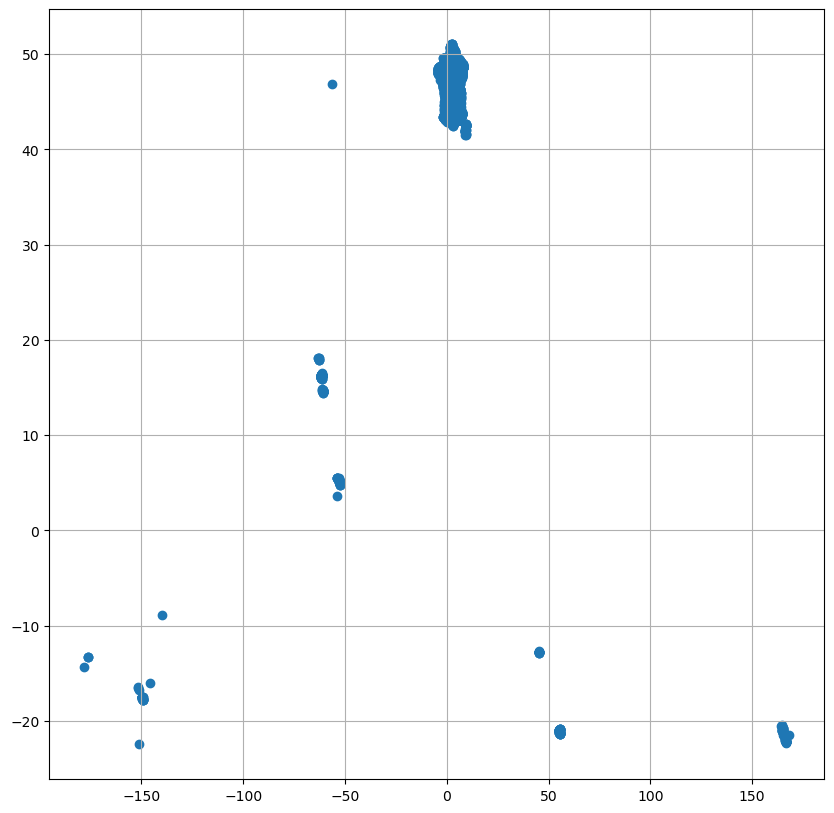

In [59]:
fig, ax = plt.subplots(figsize=(10,10))
ax.grid()
# Map of killed
killed=accid[accid['grav']==2]
ax.scatter(killed['long'],killed['lat'])

`Answer:` We are plotting the data of deadly accidents based  on latitute and longitude. Hence, we are seeing a (squeezed) map of the french territory. The big cluster corresponds to the french mainland and the scattered points are the ultramarine territories.

⏩ Let us zoom: complete the code

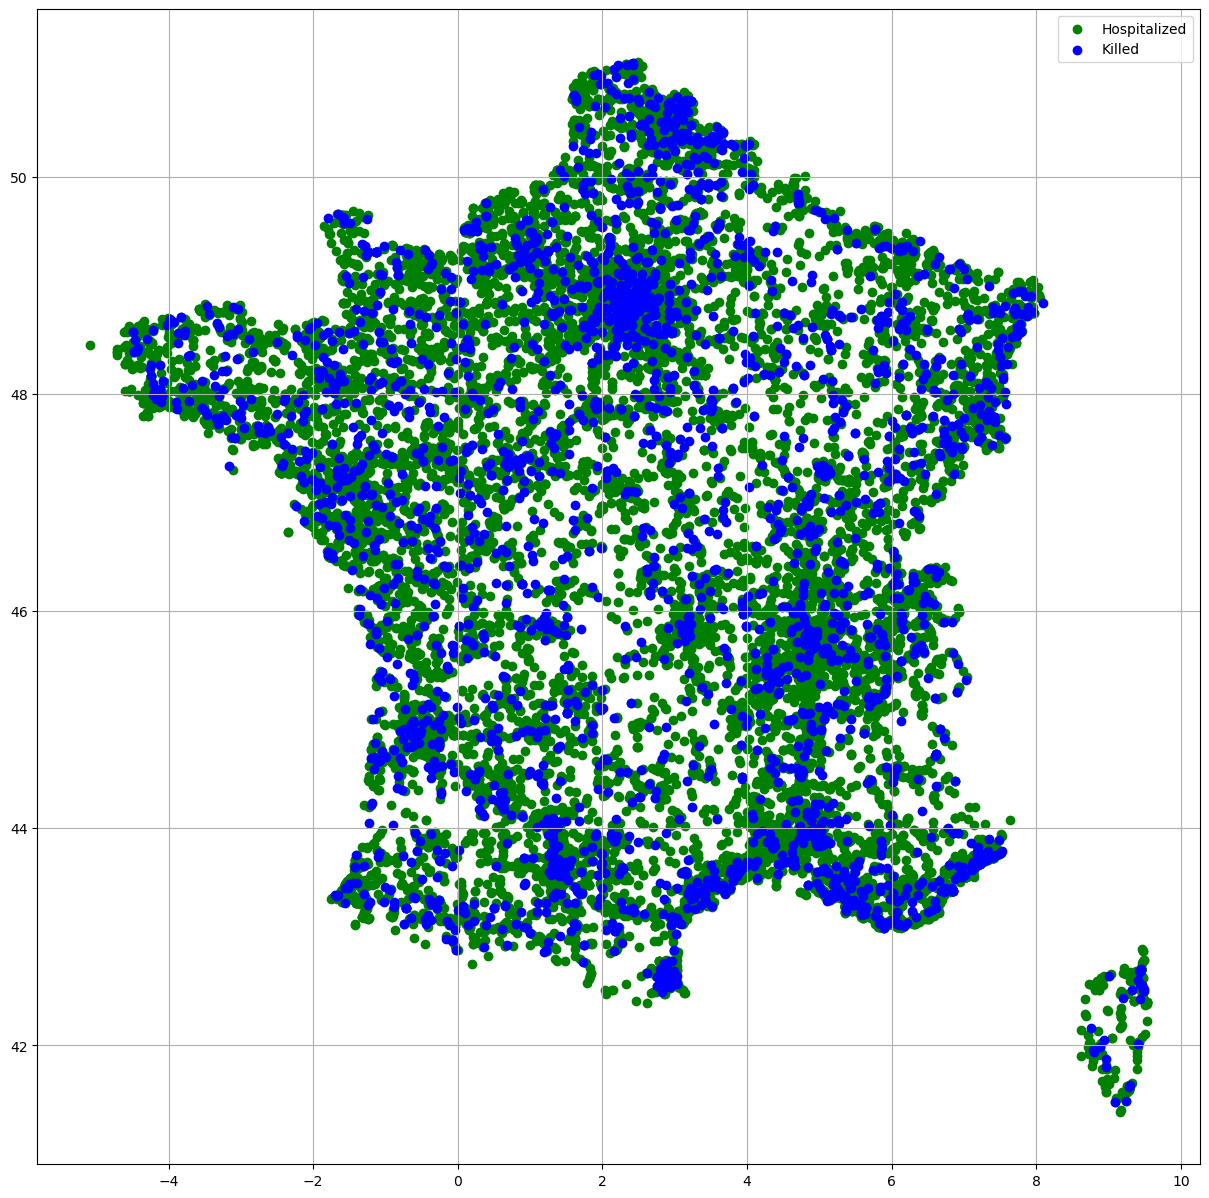

In [60]:
fig, ax = plt.subplots(figsize=(15,15))
ax.grid()

# Complete HERE
accid_met=accid[(accid['long'] >= -25  ) & (accid['lat'] >= 40)]

line1=ax.scatter(accid_met[accid_met['grav']==3]['long'],accid_met[accid_met['grav']==3]['lat'],color='green',label='Hospitalized')
line2=ax.scatter(accid_met[accid_met['grav']==2]['long'],accid_met[accid_met['grav']==2]['lat'],color='blue',label='Killed')
ax.legend(handles=[line1, line2])

⏩ How man people killed in 2021? What is the proportion of deadly accidents?

In [61]:
print(f"Number of Deadly Accidents = {accid['grav'].value_counts().iloc[3]}")
ratios = accid['grav'].value_counts() / len(accid)

Number of Deadly Accidents = 3219


In [62]:
# The ratio
print(f"Ratio of Deadly accidents = {ratios.iloc[3]}")

Ratio of Deadly accidents = 0.02492392743490279


⏩ Comment the output of the cells below

In [63]:
print(accid['sexe'].value_counts())

 1    86196
 2    39895
-1     3062
Name: sexe, dtype: int64


`Answer:` We can see that male are twice as involved in accidents with respect to females. 3062 datapoints have unknown sex.

In [64]:
print('Repartition of men casualties : \n', accid[accid['sexe']==1]['grav'].value_counts(), '\n')
print('Repartition of women casualties : \n', accid[accid['sexe']==2]['grav'].value_counts())

Repartition of men casualties : 
 1    37163
4    32873
3    13640
2     2520
Name: grav, dtype: int64 

Repartition of women casualties : 
 4    18808
1    14943
3     5445
2      699
Name: grav, dtype: int64


In [65]:
print('Repartition of men casualties : \n', accid[accid['sexe']==1]['grav'].value_counts()/accid[accid['sexe']==1].shape[0], '\n')
print('Repartition of women casualties : \n', accid[accid['sexe']==2]['grav'].value_counts()/accid[accid['sexe']==2].shape[0])

Repartition of men casualties : 
 1    0.431145
4    0.381375
3    0.158244
2    0.029236
Name: grav, dtype: float64 

Repartition of women casualties : 
 4    0.471438
1    0.374558
3    0.136483
2    0.017521
Name: grav, dtype: float64


`Answer (previous two questions):` As mentioned before, there are more males involved in accidents. Moreover, the ratios of deadly and grave accidents are slightly higher than those of female.

In [66]:
print('Accidents in built-up areas (2) and outside built-up areas (1) ; \n ',accid['agg'].value_counts(), '\n')
print('Repartition of accidents in built-up areas : \n', accid[accid['agg']==2]['grav'].value_counts(), '\n')
print('Repartition of accidents outside built-up areas : \n', accid[accid['agg']==1]['grav'].value_counts(), '\n')

Accidents in built-up areas (2) and outside built-up areas (1) ; 
  2    80749
1    48404
Name: agg, dtype: int64 

Repartition of accidents in built-up areas : 
  1    36526
 4    34024
 3     9079
 2     1067
-1       53
Name: grav, dtype: int64 

Repartition of accidents outside built-up areas : 
  1    18582
 4    17657
 3    10006
 2     2152
-1        7
Name: grav, dtype: int64 



In [67]:
print('Repartition of accidents in built-up areas : \n', accid[accid['agg']==2]['grav'].value_counts()/accid['agg'].value_counts().iloc[0], '\n')
print('Repartition of accidents outside built-up areas : \n', accid[accid['agg']==1]['grav'].value_counts()/accid['agg'].value_counts().iloc[1], '\n')

Repartition of accidents in built-up areas : 
  1    0.452340
 4    0.421355
 3    0.112435
 2    0.013214
-1    0.000656
Name: grav, dtype: float64 

Repartition of accidents outside built-up areas : 
  1    0.383894
 4    0.364784
 3    0.206718
 2    0.044459
-1    0.000145
Name: grav, dtype: float64 



`Answer:` We can observe that accidents occur mostly in built up areas. We notice, however, that the ratio of severe OR deadly accidents outside built-up areas is considerably higher (almost twice as likely). This might be explained by the fact that in non-built-up areas like highways, people go faster and accidents are more catastrophic.

### Formatting data for processing by the ML algorithm

Most features are categorical.
We will examine them one by one, possibly eliminating them, cleaning them up and categorizing them when necessary.
Some rules :
- If instances of a categorical feature are infrequent, they are combined into a single instance to avoid overfitting, otherwise the OneHot encoding will create too many new ones
unrepresentative columns,
- If the feature supposed to be numeric contains NaN, put them say at the average value of the numeric instances,
- If the digital feature contains an outlier, clip it,
- If "common sense" tells us that a feature is unlikely to have an impact on the performance of the algorithm, we eliminate it outright. 

In [68]:
# First of all, let's identify the possible lines for which the severity of the accident is unknown
accid['grav'].value_counts()

 1    55108
 4    51681
 3    19085
 2     3219
-1       60
Name: grav, dtype: int64

We drop the 60 accident of unknown severity from the data set

In [69]:
# There are 60 accidents of unknown severity. We eliminate them.
accid.drop(accid[accid['grav'] == -1].index, inplace = True)

⏩ Create a new column named `severe`, whose value is equal to one if the accident has severity `grav` 2 (hospital) or 3 (killed), and zero otherwise.

In [70]:
accid['severe'] = accid['grav'].apply(lambda x:int(x==2 or x==3))

⏩ What is the ratio of severe accidents among all accidents?

In [71]:
accid['severe'].value_counts()[1]/len(accid)

0.1727746663258271

`Answer`: Above

⏩ We investigate the 'place' feature. Explain what the following code is doing.

In [72]:
print(accid['place'].value_counts())
pd.get_dummies(accid['place']).corrwith(accid['severe'])

1     96985
2     14452
10     9474
3      2474
4      2228
9      1187
7      1101
5       608
8       437
6       147
Name: place, dtype: int64


1    -0.055343
2    -0.002466
3    -0.022634
4    -0.023905
5    -0.007795
6    -0.002064
7     0.015102
8     0.005820
9     0.008784
10    0.111036
dtype: float64

`Answer`: This code is firstly outputing the count of accidents per category in feature `place`. According to this [link](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/#/resources), this number represents the seat occupied in the vehicle by the user at the time of the accident. Values 1, 2, and 3 are common for motorcycles, cars, and buses. Values 4 to 9 apply to cars and buses. 10 are pedestrians.

Then, we are calculating the correlation index of the one hot ecoded column of a given seat with the severity of the accident. We notice our postive class is 'severe accident'. we observe, for example, that pedestrians are postively correlated with the gravity of the accident (corr = 0.11) while the driver (1) is negatively correlated (-0.06)

 Places -1, 6, 8 and 5 are not very representative and have little correlation with the severity of the accident. We will merge them into a single value, for example 20.

In [73]:
accid.place.replace([-1,6,8,5], 20,inplace=True)

⏩ Inspect the catu attribute (1=driver, 2=passenger, 3=pedestrian). Which of these values is the most correlated with the severity of the accident?

In [74]:
pd.get_dummies(accid['catu']).corrwith(accid['severe'].sort_values())
#accid[accid['catu'] == 1].corrwith(accid['severe'])

1   -0.055758
2   -0.012967
3    0.111036
dtype: float64

`Answer`: As we can see from the correlation list above, pedestrians are the most correlated with the gravity of the accident. The correlation is positive.

⏩ Inspect the 'trajet' column. What type of travel seems to be correlated with severe injuries?

In [75]:
pd.get_dummies(accid['trajet']).corrwith(accid['severe']).sort_values(ascending=False)


 5    0.131597
 3    0.030191
 2   -0.004075
 1   -0.020816
 9   -0.025498
 0   -0.039289
-1   -0.069031
 4   -0.088147
dtype: float64

`Answer:` We can see in the list above that the value 5 is the most postively correlated with accidents. 5 represents that the involved drivers were traveling for leisure. Value of 4 is the most negatively correlated to the accidents (indicating they were going to work). Still, the correlation coefficients are not too high for any of the categories.

value keys:

- *-1* – Not specified
- *0* – Not specified
- *1* – Home to work
- *2* – Home to school
- *3* – Shopping and errands
- *4* – Professional use
- *5* – Recreation and leisure
- *9* – Other

⏩ Inspect the 'an_nais' column, which corresponds to the birth year. In case you find that there are missing values, do something appropriate.

In [76]:
accid['an_nais'].isna().sum()

3007

We observe that there are 3000 missing values for the age. We will simply replace the age for the mean of the known birth years. 

In [77]:
# YOUR CLEANING PROCEDURE HERE
accid['an_nais'] = accid['an_nais'].fillna(accid['an_nais'].mean())

We transform secu1, secu2 and secu3 => security equipment.

 There are three columns because a user can use up to three devices.

 We do a OneHot encoding "by hand"

In [78]:
accid['belt'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==1)|(x[1]==1)|(x[2]==1)),axis=1)
accid['helmet'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==2)|(x[1]==2)|(x[2]==2)),axis=1)
accid['child_equip'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==3)|(x[1]==3)|(x[2]==3)),axis=1)
accid['airbag'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==5)|(x[1]==5)|(x[2]==5)),axis=1)
accid['no_equip'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==0)&(x[1]==0)&(x[2]==0)),axis=1)


⏩ Drop 'secu1','secu2','secu3' columns

In [79]:
accid.drop(columns=['secu1', 'secu2', 'secu3'],inplace=True)

Inspect the vma columns, which corresponds to the maximal speed in km/h. Draw a boxplot of the column. Are some values absurd?

<class 'pandas.core.series.Series'>
Int64Index: 129093 entries, 0 to 129152
Series name: vma
Non-Null Count   Dtype
--------------   -----
129093 non-null  int64
dtypes: int64(1)
memory usage: 6.0 MB
None


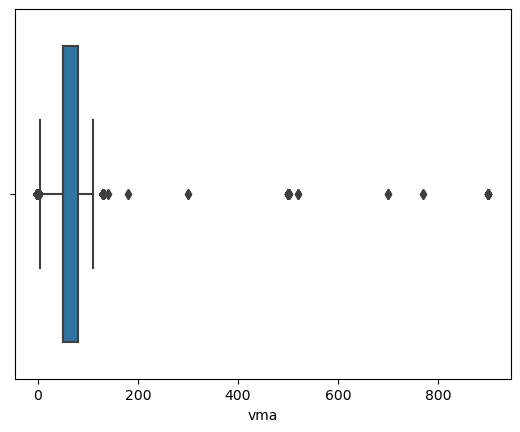

In [80]:
print(accid['vma'].info())
sns.boxplot(x=accid['vma'])
plt.show()

In [81]:
print(accid[accid['vma'] < 0]['vma'])

170      -1
171      -1
172      -1
182      -1
183      -1
         ..
128647   -1
128780   -1
129043   -1
129044   -1
129045   -1
Name: vma, Length: 1870, dtype: int64


In [82]:
print(accid[accid['vma'] >200]['vma'][:10])

7997     700
14792    900
14793    900
14794    900
19613    500
19614    500
20587    300
20588    300
30783    900
30784    900
Name: vma, dtype: int64


`Answer:` We can observe from the boxplot and the sample data above that some speed values indeed are absurd. Some  values are above 300 km/h (and some over 800km/h).  Other speeds are equal -1 km/h, which is also nonsensical (probably indicating the data was not available). We need to clean this data. 

⏩ What is the following code doing?

In [83]:
accid['vma_clipped'] = accid['vma'].clip(lower = 0, upper = 200)

`Answer:` In the following code, we limit the values of 'vma' to be between 0 and 200, inclusive. Any value less than 0 will be replaced with 0 and any value greater than 200 will be replaced with 200. The resulting values are then assigned to the new column 'vma_clipped'. This way, we trim the outliers.

# PART 2. Binary Classification
We propose to keep the following columns. Note that there are many columns for which we did not use any feature engineering or cleansing, feel free to do it in order to improve the results!

In [84]:
columns_to_keep = ['place', 'catu', 'sexe', 'an_nais',
       'trajet', 'lum', 'agg','surf',
       'atm',  'belt', 'helmet', 'child_equip', 'airbag', 'no_equip',
       'vma_clipped','locp',  'etatp', 'catv', 'obs', 'obsm', 'motor', 'int','catr', 'circ', 'nbv', 'prof']
accid[columns_to_keep].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129093 entries, 0 to 129152
Data columns (total 26 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   place        129093 non-null  int64  
 1   catu         129093 non-null  int64  
 2   sexe         129093 non-null  int64  
 3   an_nais      129093 non-null  float64
 4   trajet       129093 non-null  int64  
 5   lum          129093 non-null  int64  
 6   agg          129093 non-null  int64  
 7   surf         129093 non-null  int64  
 8   atm          129093 non-null  int64  
 9   belt         129093 non-null  int64  
 10  helmet       129093 non-null  int64  
 11  child_equip  129093 non-null  int64  
 12  airbag       129093 non-null  int64  
 13  no_equip     129093 non-null  int64  
 14  vma_clipped  129093 non-null  int64  
 15  locp         129093 non-null  int64  
 16  etatp        129093 non-null  int64  
 17  catv         129093 non-null  int64  
 18  obs          129093 non-

⏩ Perform the train-test split, keeping only the above `columns_to_keep` list

So far, we are only interested in binary classification, so the label column would be `accid['severe']`. However, we will later be interested in multiclass classification. Therefore, you can have two label columns `accid[['severe','grav']]`

In [85]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(accid[columns_to_keep], accid[['severe','grav']],train_size=0.06)

⏩ Run the next cell. If one had to use onehot encoding, how many columns would we have?

In [111]:
a = x_train.nunique()
print(a.sum())
print(a)

296
place           8
catu            3
sexe            3
an_nais        99
trajet          8
lum             5
agg             2
surf           10
atm            10
belt            2
helmet          2
child_equip     2
airbag          2
no_equip        2
vma_clipped    19
locp           11
etatp           4
catv           29
obs            19
obsm            8
motor           7
int             9
catr            8
circ            5
nbv            14
prof            5
dtype: int64


`Answer:` We would have 296 colums

Running value_counts() on some columns, we observe that some values are quite rare. They bring complexity into the model, but little information to learn from. It might be wise to merge rare values into a single "bin". We do not handle this here, but you may try this at home if you wish.

In [42]:
x_train['surf'].value_counts()

 1    6224
 2    1398
 7      34
 9      31
 5      29
 3      15
 8       9
 6       3
 4       1
-1       1
Name: surf, dtype: int64

Surface condition:
- *-1* - Not specified
- *1* - Normal
- *2* - Wet
- *3* - Puddles
- *4* - Flooded
- *5* - Snow-covered
- *6* - Mud
- *7* - Icy
- *8* - Greasy - oil
- *9* - Other

## Decision tree
⏩ Train a decision tree, using the default parameters.

In [231]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(min_samples_split = 2)
dt.fit(x_train, y_train['severe'])

DecisionTreeClassifier()

⏩ Compute the accuracy score. You should find something around 80% of correct predictions. Not bad for a decision tree? 

In [232]:
from sklearn.metrics import accuracy_score
accuracy_score(dt.predict(x_test), y_test.severe)

0.7833091604311567

⏩ Compare the accuracy of the classifier which outputs "0" for every input, and explain.

In [233]:
accuracy_score(np.zeros(len(y_test.severe)), y_test.severe)

0.827092329498632

`Answer:` The reason we have such a high accuracy with this constant classifier is because we have a very unbalanced dataset. The number of non-severe accidents is very high (about 83%) so our model can get away with just predicting 0s, for example. Therefore, accuracy is not the best of metrics when considering the performance of our model.

⏩ Compute the area under the ROC curve for the decision tree 

0.6300455605099956


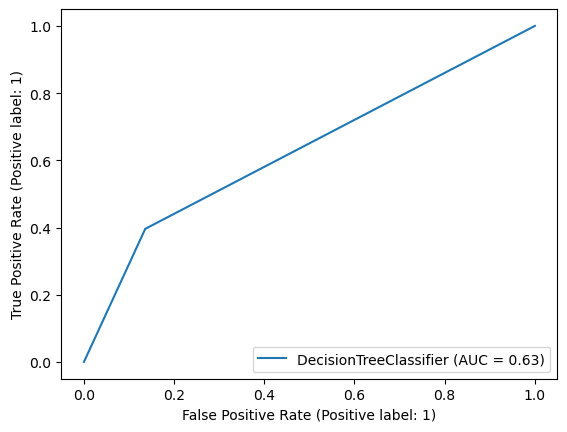

In [234]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

print(roc_auc_score(y_test.severe, dt.predict_proba(x_test)[:, 1]))
dt.predict_proba(x_test)[:, 1]
RocCurveDisplay.from_estimator(dt, x_test, y_test.severe)

In [238]:
dt.predict_proba(x_test)[:, 1][:100]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

Our predict proba shows that the decision tree classifier has leafs with perfect purity, so it is alway absolutely certain on its classification. This is because our tree is too deep. We could hyperparameter tune the classifier and get a smoother roc curve in exchange. Still, a random forest would perform much better.

## Random Forest
⏩ Train a random forest classifier, using the default parameters. 

Provide the accuracy score and the AUC.


In [91]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train.severe)

RandomForestClassifier()

Decision tree classifier accuracy score = 0.8483699772554966
Decision tree classifier area under ROC = 0.828552709883276


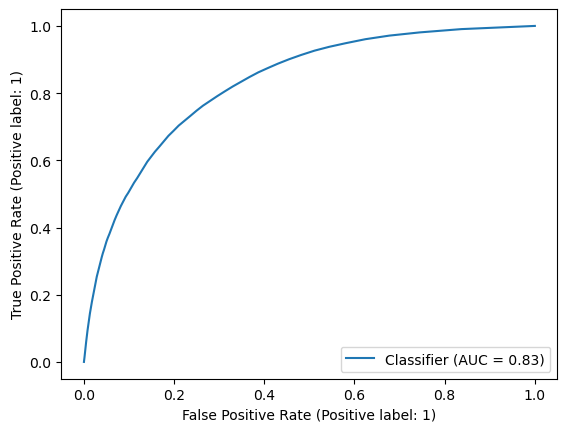

In [92]:
y_pred_rfc = rfc.predict_proba(x_test)[:, 1]
y_pred_rfc_hard = rfc.predict(x_test) > 0.5
print(f"Decision tree classifier accuracy score = {accuracy_score(y_test.severe, y_pred_rfc_hard)}")
print(f"Decision tree classifier area under ROC = {roc_auc_score(y_test.severe, y_pred_rfc)}")
RocCurveDisplay.from_predictions(y_test.severe, y_pred_rfc)

In [93]:
y_pred_rfc[:100]

array([0.07  , 0.35  , 0.08  , 0.44  , 0.1   , 0.    , 0.11  , 0.07  ,
       0.42  , 0.89  , 0.04  , 0.    , 0.12  , 0.62  , 0.    , 0.12  ,
       0.87  , 0.34  , 0.01  , 0.13  , 0.59  , 0.14  , 0.33  , 0.03  ,
       0.3   , 0.    , 0.4   , 0.08  , 0.15  , 0.5675, 0.17  , 0.27  ,
       0.    , 0.    , 0.1   , 0.25  , 0.54  , 0.01  , 0.54  , 0.14  ,
       0.18  , 0.25  , 0.02  , 0.74  , 0.02  , 0.    , 0.22  , 0.07  ,
       0.01  , 0.02  , 0.    , 0.05  , 0.94  , 0.03  , 0.37  , 0.    ,
       0.39  , 0.56  , 0.8   , 0.14  , 0.01  , 0.58  , 0.77  , 0.11  ,
       0.11  , 0.04  , 0.42  , 0.03  , 0.36  , 0.01  , 0.65  , 0.02  ,
       0.24  , 0.17  , 0.13  , 0.37  , 0.02  , 0.12  , 0.    , 0.01  ,
       0.52  , 0.04  , 0.02  , 0.01  , 0.01  , 0.09  , 0.04  , 0.28  ,
       0.28  , 0.01  , 0.43  , 0.    , 0.24  , 0.01  , 0.04  , 0.02  ,
       0.29  , 0.05  , 0.39  , 0.06  ])

⏩ Now set `min_samples_split` to a higher value than the default value 2. Compare the performance, and explain.



In [101]:
acc_scores = []
roc_aucs = []
for samples in range(2, 50, 1):
    rfc = RandomForestClassifier(min_samples_split=samples)
    rfc.fit(x_train, y_train.severe)
    y_pred_rfc = rfc.predict_proba(x_test)[:, 1]
    y_pred_rfc_hard = y_pred_rfc > 0.5
    acc_score = accuracy_score(y_test.severe, y_pred_rfc_hard)
    roc_auc = roc_auc_score(y_test.severe, y_pred_rfc)
    acc_scores.append(acc_score)
    roc_aucs.append(roc_auc)



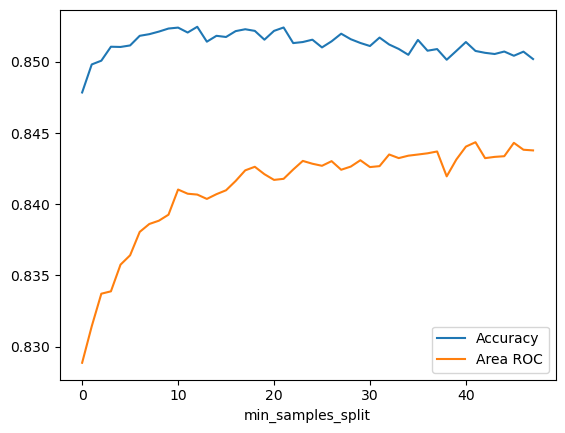

In [102]:
plt.plot(acc_scores)
plt.plot(roc_aucs)
plt.legend(["Accuracy", "Area ROC"], loc=0)
plt.xlabel("min_samples_split")
plt.show()

In [100]:
print(f"Min samples split with best AUC = {np.argmax(roc_aucs) + 2}, with AUC = {max(roc_aucs)}")
print(f"Min samples split with best accuracy = {np.argmax(acc_scores) + 2}, with acuracy = {max(acc_scores)}")

Min samples split with best AUC = 42, with AUC = 0.8443567335184148
Min samples split with best accuracy = 14, with acuracy = 0.852630451264133


`Answer:` `min_samples_split` is the minimum number of samples required to split an internal node for every tree in the random forest. This is a critical paramater for a decision tree. Higher values result in different, less complex partitions of the data. Generally, it is desierable in random forest algorithms to have simple decision trees to avoid overftting and bias. This is why we achieve slightly better ROC curve values as we increase this parameter. 

⏩ What does the `n_estimators` parameter refers to? What is the default value? You may try to play with this parameter if time permits.

`Answer:` `n_estimators` is the number of trees in the forest. The default value is 100 (from scikit learn documentation)


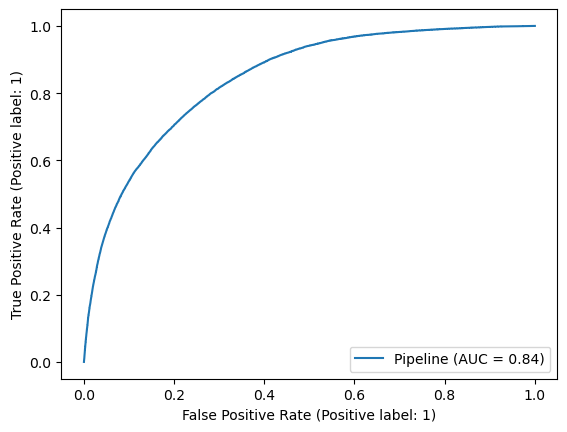

In [95]:
#We create a simple pipleine to play around with some values of n_estimator and minium sample split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

model_rfc = Pipeline([('classifier', RandomForestClassifier()) ] )

params_rfc = {'classifier__min_samples_split': [2, 5, 10, 30, 50], 
         'classifier__n_estimators': [32, 128, 256, 512]}

grid_rfc = GridSearchCV(model_rfc, params_rfc, cv=5, scoring='roc_auc')
grid_rfc.fit(x_train, y_train.severe)

RocCurveDisplay.from_estimator(grid_rfc.best_estimator_, x_test, y_test.severe)


In [98]:
grid_rfc.best_estimator_

Pipeline(steps=[('classifier',
                 RandomForestClassifier(min_samples_split=50,
                                        n_estimators=128))])

⏩ Explain what `rf.feature_importances_` refers to. Plot bars of feature importances. Comment the result. 

<AxesSubplot:>

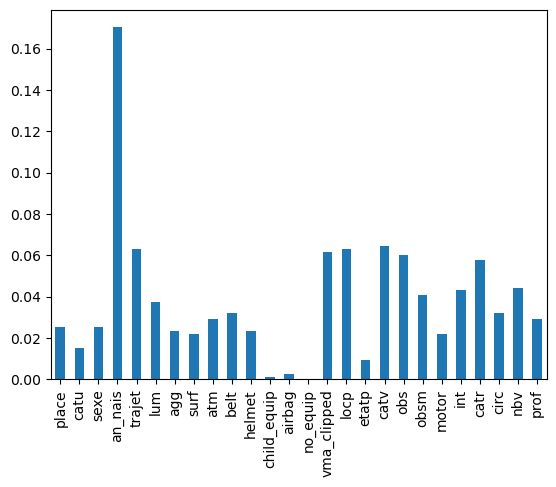

In [54]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train.severe)
rf_importances = pd.Series(rfc.feature_importances_, index=columns_to_keep)
rf_importances.plot.bar()
# n.b. One should treat this information with caution. 
# Indeed, numerical attributes tend to be more often chosen as a split, because they are harder to learn than, for instance, binary attributes.
# As a consequence, they may naturally end up with a higher feature importance

`Answer:` The importance of a feature is computed as the (normalized) total reduction of the impurity criterion brought by that feature. However, this score tends to be biased towards features with many categories. This is because when splitting on a high cardinality feature, the algorithm may create many branches in the tree, each with a small number of instances. As a result, the feature may appear to have high importance because it creates many splits and reduces impurity in each branch, but in reality, these splits are just overfitting. We can see clearly that the age of birth of the driver had the highest importance but also the highest cardinality.

## XGBoost
⏩ Train a XGBoost classifier, using the default parameters. 

Provide the accuracy score and the AUC.

Try to change the `learning_rate` and `n_estimators` parameters

In [121]:
import xgboost 
from xgboost import XGBClassifier

In [122]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train.severe)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [123]:
y_pred_xgb = xgb.predict_proba(x_test)[:, 1]
y_pred_xgb_hard = y_pred_xgb > 0.5
print(f"XGB classifier accuracy score = {accuracy_score(y_test.severe, y_pred_xgb_hard)}")
print(f"XGB classifier area under ROC = {roc_auc_score(y_test.severe, y_pred_xgb)}")

XGB classifier accuracy score = 0.8429805188383822
XGB classifier area under ROC = 0.8256070780181977


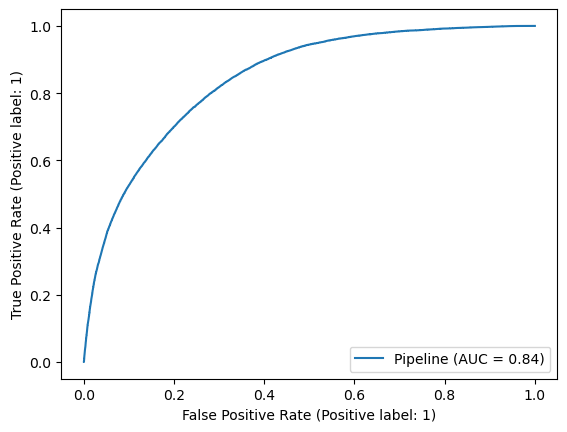

In [124]:
model_xgb = Pipeline([('classifier', XGBClassifier()) ] )

params_xgb = {'classifier__learning_rate': [0.01, 0.05, 0.075, 0.1, 0.3], 
         'classifier__n_estimators': [32, 128, 256]}

grid_xgb = GridSearchCV(model_xgb, params_xgb, cv=5, scoring='roc_auc')
grid_xgb.fit(x_train, y_train.severe)

RocCurveDisplay.from_estimator(grid_xgb.best_estimator_, x_test, y_test.severe)

In [126]:
grid_xgb.best_estimator_

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=128,
                               n_jobs=None, n

128 estimators and 0.05 learning rate have the best performance.

## Logistic regression

We now compare the result to logistic regression. To this end, we first need to onehot encode all categorical columns. We use sklearn onehotencoder.

⏩ Fill the code below

In [166]:
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['place', 'catu', 'sexe', 
       'trajet', 'lum', 'agg','surf',
       'atm',  'belt', 'helmet', 'child_equip', 'airbag', 'no_equip',
       'locp',  'etatp', 'catv', 'obs', 'obsm', 'motor', 'int','catr', 'circ', 'nbv', 'prof']

ec = OneHotEncoder()

dummy_cols = ec.fit_transform(x_train[categorical_features])

⏩ What is the type of `dummy_cols`? What is the interest of using this type? 

In [167]:
type(dummy_cols)

scipy.sparse._csr.csr_matrix

In [168]:
dummy_cols.data.nbytes/dummy_cols.toarray().data.nbytes

0.1348314606741573

`Answer`: Our matrix has many 0 entries a very few amount of 1s (we say it is a sparse matrix). Hence, we have lots of redundant information. Sklearn's one hot encoder returns a compressed version of this sparse matrix,anotating only the non zero values. We can see that the compression reduces the size of the data to almost 1/10th of the original version.

In this example, not all the attributes are categorical. We use ColumnTransformer in order to onehotencode the categorical columns, and leave the remaining columns unchanged.

In [169]:
from sklearn.compose import ColumnTransformer
transformer=ColumnTransformer( transformers=[('OneHot',OneHotEncoder(handle_unknown='ignore'),categorical_features)],remainder="passthrough")
x_train_oh = transformer.fit_transform(x_train)

We print the first line: notice the dummy variables and the numerical variable at the end.

In [170]:
x_train_oh.toarray()[0]

array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

⏩ How many rows/colums does x_train_oh contains?

In [171]:
x_train_oh.shape

(7745, 180)

`Answer:` It contains 180 columns and 7745 rows.

Some columns have only a small number of ones. Here, we decide to delete these columns before training/ Of course, smarter approaches could be used (more detailed EDA, Lasso, etc.)

In [115]:
number_of_ones = sum(x_train_oh).toarray()

In [116]:
cols = [ i for i in range (177) if number_of_ones[0][i]>200]
x_train_lr = x_train_oh[:,cols]

⏩ Fit a logistic regression

In [117]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 10000)
lr.fit(x_train_lr, y_train.severe)

LogisticRegression(max_iter=10000)

We transform x_test similarly to x_train, using the previous ColumnTransformer

In [118]:
x_test_oh = transformer.transform(x_test)
x_test_lr = x_test_oh[:,cols]

⏩ Provide the accuracy and the AUC of the logistic regression

Logistic classifier accuracy score = 0.8476859940007252
Logistic classifier area under ROC = 0.8322292271405709


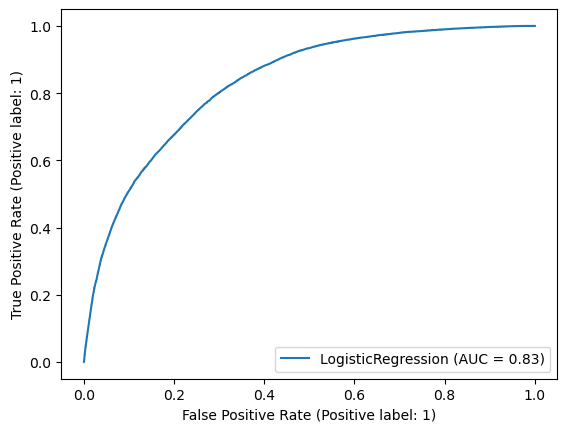

In [119]:
y_pred_lr = lr.predict_proba(x_test_lr)[:, 1]
y_pred_lr_hard = y_pred_lr > 0.5
print(f"Logistic classifier accuracy score = {accuracy_score(y_test.severe, y_pred_lr_hard)}")
print(f"Logistic classifier area under ROC = {roc_auc_score(y_test.severe, y_pred_lr)}")
RocCurveDisplay.from_estimator(lr, x_test_lr, y_test.severe)

# Intermision: Why are we getting similar curves?

Let's compare the three roc curves we have obtained so far: logistic, random forest, and XGBoost.

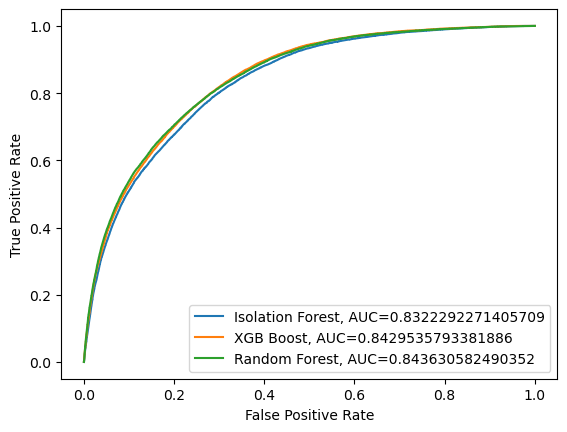

In [127]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test.severe,  lr.predict_proba(x_test_lr)[:, 1])
auc = roc_auc_score(y_test.severe,  lr.predict_proba(x_test_lr)[:, 1])
plt.plot(fpr,tpr, label="Isolation Forest, AUC="+str(auc))

fpr, tpr, _ = roc_curve(y_test.severe,  grid_xgb.best_estimator_.predict_proba(x_test)[:, 1])
auc = roc_auc_score(y_test.severe,  grid_xgb.best_estimator_.predict_proba(x_test)[:, 1])
plt.plot(fpr,tpr, label="XGB Boost, AUC="+str(auc))

fpr, tpr, _ = roc_curve(y_test.severe,  grid_rfc.best_estimator_.predict_proba(x_test)[:, 1])
auc = roc_auc_score(y_test.severe,  grid_rfc.best_estimator_.predict_proba(x_test)[:, 1])
plt.plot(fpr,tpr, label="Random Forest, AUC="+str(auc))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

Indeed we observe that the roc curves are extremely similar, with similar AUC values as well. So I am afrad I have made a silly mistake and trained the same model over and over again.

However, it is the case that ROC curves are some times insensitive to inbalanced ddatasets. We can still try to use another curve that is perhaps more visually representative of the defferences between the classifiers. Enters the precision recall curve. 

**From sklearn documentation:** The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

**Me:** Every precision recall curve approximates to the lower right cornner, which means a perfet recall with very small precision. This occurs when our model decides to predict only the prositive class.

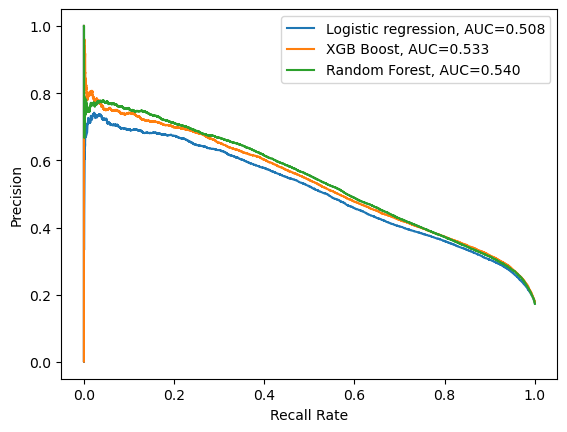

In [146]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _  = precision_recall_curve(y_test.severe,  lr.predict_proba(x_test_lr)[:, 1])
auc = average_precision_score(y_test.severe,  lr.predict_proba(x_test_lr)[:, 1])
plt.plot(rec, prec, label="Logistic regression, AUC="+str('%.3f'%(auc)))

prec, rec, _  = precision_recall_curve(y_test.severe,  grid_xgb.best_estimator_.predict_proba(x_test)[:, 1])
auc = average_precision_score(y_test.severe,  grid_xgb.best_estimator_.predict_proba(x_test)[:, 1])
plt.plot(rec, prec, label="XGB Boost, AUC="+str('%.3f'%(auc)))

prec, rec, _  = precision_recall_curve(y_test.severe,  grid_rfc.best_estimator_.predict_proba(x_test)[:, 1])
auc = average_precision_score(y_test.severe,  grid_rfc.best_estimator_.predict_proba(x_test)[:, 1])
plt.plot(rec, prec, label="Random Forest, AUC="+str('%.3f'%(auc)))

plt.ylabel('Precision')
plt.xlabel('Recall Rate')
plt.legend()
plt.show()

We finally observe some differences! After resinspecting the code and the curves, we rest assured we have not committed any mistakes. We still wonder about the extreme variance that occurs on the left of our precision-recall curve.

In [156]:
prec, rec, _ = precision_recall_curve(y_test.severe,  grid_xgb.best_estimator_.predict_proba(x_test)[:, 1])
k = [(rec[i], prec[i]) for i in range(len(prec))]

Inspecting the first few values plotted on the curve we have our answer

In [157]:
k[-10:]

[(0.0003812791916881136, 0.8888888888888888),
 (0.0003336192927270994, 0.875),
 (0.00028595939376608524, 0.8571428571428571),
 (0.00023829949480507102, 0.8333333333333334),
 (0.0001906395958440568, 0.8),
 (0.00014297969688304262, 0.75),
 (9.53197979220284e-05, 0.6666666666666666),
 (4.76598989610142e-05, 0.5),
 (0.0, 0.0),
 (0.0, 1.0)]

Remember:

`precision =  true_postive / (true_positive + false_positive)`

`recall =  true_postive / (true_positive + false_negative)`

On the precision recall curve, our threshold begins classifying everthing as the negative class, so we have 0 true postives and 0 recall, so we have 0, 0 as starter point. After that, our threshold moves point by point calculating again both metrics. Observe that the precision ratio is very senstive when the number of overall predicted positives is very small (corresponding to the left of our curve).

For example, if we have classified 3 positive values and one of them is true, our precision would be 0.333. If our threshold moves one point, the number of positive values is 4 and assume we predicted another true postive. Then our new precision is 0.5. This jump is huge, so we need a big amount of positve predictions for the curve to stabilize.

This is the extreme variance we observe. 

Our conclusion is that the imbalanced dataset is causing the models to learn similar features. This results in similar ROC curves despite the differences in learning.



# PART 3. Multiclass classification

We now would like to predict the class (1,2,3,4) in the `grav` label). Recall that 1=free, 2=killed, 3=severe_injury, 4=slight_injury

⏩ Fit a `LogisticRegression` classifier using the argument `multi_class='multinomial'`. What is the name of the loss function used by this classifier?

In [163]:
lr = LogisticRegression(max_iter = 1000000, multi_class='multinomial', solver = "lbfgs")
lr.fit(x_train_lr, y_train.grav)

LogisticRegression(max_iter=1000000, multi_class='multinomial')

The loss function used in this classifier is called the cross entropy. The cross-entropy contribution of every point $y$ is calculated as $-\sum_{c = 1}^{M} y_{c}\log{p_c(y)}$, where $M$ is the number of classes, $y_c$ is the label whether $y$ belongs to the class $c$, and $p_c(y) = p(X \in c|X=y)$, i.e. the probabiltiy of class $c$ outputed by the classifier for datapoint $y$.

The next cells give an example of the output classifier, in terms of scores and hard decisions

In [172]:
print("Output probabilities of the 0th test input: ",lr.predict_proba(x_test_lr[0]))
print("Hard decision of the 0th test input: ", lr.predict(x_test_lr[0]), "... that is the argument of the maximum probability")

Output probabilities of the 0th test input:  [[0.6977594  0.00914848 0.08542618 0.20766594]]
Hard decision of the 0th test input:  [1] ... that is the argument of the maximum probability


⏩ Print the confusion matrix, and provide your comment about its structure. Explain.

In [173]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_test.grav, lr.predict(x_test_lr))
print(confmat)

[[42421     5  1019  8409]
 [  593     2  1175  1261]
 [ 3356     2  5352  9241]
 [14956    10  2964 30582]]


<AxesSubplot:>

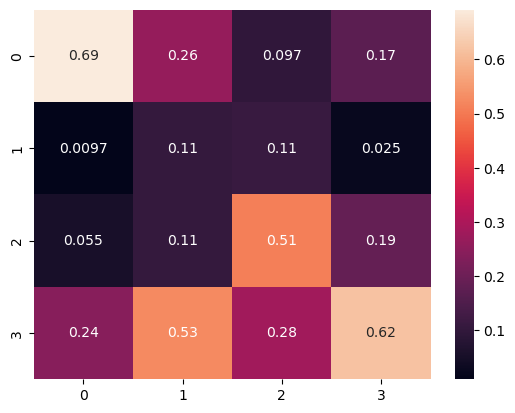

In [174]:
# We normalize the confusion matrix in such a way that every column has a sum equal to one
confusion_probabilities = confmat / sum(confmat)
sns.heatmap(confusion_probabilities,annot=True)

`Answer:` From sklearn: By definition a confusion matrix $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$. This means that the row represents the correct class, and the column the predicted class. 

We are interested in having a matrix which main diagonal values are as big as possible, as these reflect that our model accurately classified the data. In the confusion matrix above, we see that the main diagonal entries dominate each row (with the exception of class 2). Still, we have plenty of missclasifications (the sum of the non-main-diagonal-entries).

Some of the missclassifications make sense. For example, we can see that the entry $C_{41}$ is a big number. In this case, our model predicts the people scaped the accident safely, while in reality, they were slightly injured. 

On the other hand, we can see that our model has problems detecting deadly accidents (row 2), missclasifying most of the time. And when it predicts a deadly accident (column 2), it is unlikely to be an actual one.

⏩ Re-train a logistic classifier, but now use the argument `class_weight='balanced'`. Observe the confusion matrix. Explain.

In [192]:
lr = LogisticRegression(max_iter = 10000, multi_class='multinomial', solver = "lbfgs", class_weight = 'balanced')
lr.fit(x_train_lr, y_train.grav)

LogisticRegression(class_weight='balanced', max_iter=10000,
                   multi_class='multinomial')

In [193]:
confmat = confusion_matrix(y_test.grav, lr.predict(x_test_lr))
print(confmat)

[[38502  4810  2451  6091]
 [  235  1421  1025   350]
 [ 1719  5438  6906  3888]
 [12371  6569  8552 21020]]


<AxesSubplot:>

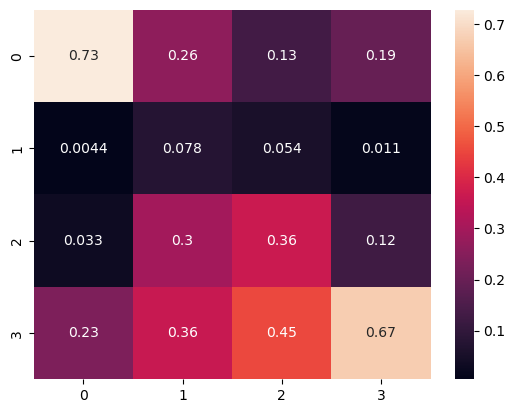

In [194]:
# We normalize the confusion matrix in such a way that every column has a sum equal to one
confusion_probabilities = confmat / sum(confmat)
sns.heatmap(confusion_probabilities,annot=True)

`Answer:` `class_weight = 'balanced'` is a way to deal with our imbalanced dataset. What's going on here is that our penalty is reweighted so that we do not multiply a missclassification by 1 but by `weights[i]`. In the case of `balanced`, `weights[i] = n_samples / (n_classes * np.bincount(i))`. Then, the missclasification of data from the dominant classes are less penalized, and the less predominat classes have a greater penalty. In this way, we emphasize the importance of a correctly classified datapoint from the minority class. in this dataset, we observe that for the class killed and gravely injured, our true recall improved quite a bit (we went from 2 deadly predicitons to 1476). Still, we lost on the precision. 

⏩ Train a random forest (using `class_weight='balanced'`) and plot the (normalized) confusion matrix

In [195]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(x_train, y_train.grav)

RandomForestClassifier(class_weight='balanced')

[[40527    94  1249  9984]
 [  498   130  1143  1260]
 [ 3153   229  5484  9085]
 [14005   135  3424 30948]]


<AxesSubplot:>

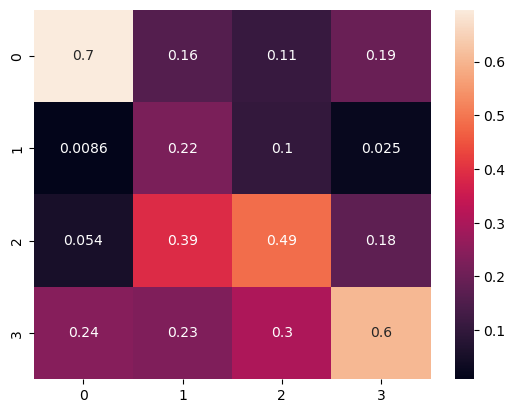

In [196]:
confmat = confusion_matrix(y_test.grav, rf.predict(x_test))
print(confmat)
confusion_probabilities = confmat / sum(confmat)
sns.heatmap(confusion_probabilities,annot=True)

In order to compare the performance of two classifiers using a single measure, one option is to compute the log_loss, or cross entropy loss [see here](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression)

To this end we first need, to format the label column using a `LabelBinarizer`


In [197]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_train.grav)

LabelBinarizer()

In [198]:
# Here is what the LabelBinarizer output looks like
labels = lb.transform(y_test.grav)

In [199]:
# To be compared with the output probability scores
predicted_proba_rf = rf.predict_proba(x_test)

⏩ Compare the log_loss of random forest to logistic regression, and to XGBoost.

In [200]:
from sklearn.metrics import log_loss
print(f'log loss of random forest = {log_loss(labels, predicted_proba_rf)}')

log loss of random forest = 1.0100917197063095


In [187]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_XGB = le.fit_transform(y_train.grav)
xgb = XGBClassifier()
xgb.fit(x_train, y_train_XGB)
predicted_proba_xgb = xgb.predict_proba(x_test)
print(f'log loss of XGB = {log_loss(labels, predicted_proba_xgb)}')

log loss of XGB = 0.8546856371653178


In [191]:
predicted_proba_lr = lr.predict_proba(x_test_lr)
print(f'log loss of lr = {log_loss(labels, lr.predict_proba(x_test_lr))}')

log loss of lr = 1.0148516754760288


# Looking for hyperparameters in multinomial setting

To get a feel on how much we can improve the base parameters, we do a small hyperparameter grid search. We emply 3 fold cross validation to prevent long waitings and score on the log loss, not the accuracy, to determine the best parameters.

In [203]:
rf = RandomForestClassifier()

param = {
    'n_estimators': [10, 100, 200],
    'max_depth': [5, 10, None],
    'class_weight': [None, 'balanced'],
}

grid_rf = GridSearchCV(rf, param, cv=3, scoring='neg_log_loss')
grid_rf.fit(x_train, y_train.grav)

print(grid_rf.best_params_)

{'class_weight': None, 'max_depth': 10, 'n_estimators': 200}


In [205]:
print("best random forest log loss = ", log_loss(labels, grid_rf.best_estimator_.predict_proba(x_test)))

0.815808025850131

In [218]:
xgb = XGBClassifier()

params = {'eta': [0.1, 0.3, 0.8], 
        'gamma': [0, 1, 2],
        'max_depth': [3, 5, 6, 7]
       }

grid_xgb = GridSearchCV(xgb, params, cv=3, scoring='neg_log_loss')
grid_xgb.fit(x_train, y_train_XGB)

print(grid_xgb.best_params_)

{'eta': 0.1, 'gamma': 2, 'max_depth': 7}


In [223]:
print("best xgb log loss = ", log_loss(labels, grid_xgb.best_estimator_.predict_proba(x_test)))

best xgb log loss =  0.7989270263867324


In [227]:
lr = LogisticRegression(max_iter = 10000, multi_class='multinomial', solver = "lbfgs")

params = {'C': [0.1, 0.5, 1.0], 
        'tol': [1e-4, 1e-3],
        'class_weight': [None, 'balanced']}

grid_lr = GridSearchCV(lr, params, cv=3, scoring='neg_log_loss')
grid_lr.fit(x_train_lr, y_train.grav)

print(grid_lr.best_params_)

{'C': 0.5, 'class_weight': None, 'tol': 0.0001}


In [230]:
print("best logistic regression logloss = ", log_loss(labels, grid_lr.best_estimator_.predict_proba(x_test_lr)))

best logistic regression logloss =  0.8223965027142444


# Conclusion

In this notebook, we have seen how to 

*   Perform an EDA (although more could have been done)
*   Clean up a data set
*   Use random forest and XGBoost
*   Use sklearn onehotencoder, columnencoder
*   Handle mutliclass classification using log_loss, confusion matrices
*   Deal with unbalanced data sets



### Meanings of the different fields in the three data files

#### In *carac_accidents_2021.csv*

Num_Acc: Identification number of the accident. The same in the other DataFrames

day, month, year: day of the accident, month of the accident, year of the accident.

hrmn: hour and minute of the accident.

lum: light, lighting conditions in which the accident occurred:

   1 – Full day

   2 – Dusk or dawn

   3 – Night without public lighting

   4 – Night with public lighting not on

   5 – Night with public lighting on

dep Department: INSEE code (National Institute of Statistics and Economic Studies) of department (2A Corse-du-Sud – 2B Haute-Corse).

agg: location:

   1 – Outside agglomeration

   2 – In built-up areas

int: intersection:

   1 – Out of intersection

   2 – X intersection

   3 – T-junction

   4 – Y intersection

   5 – Intersection with more than 4 branches

   6 – Roundabout

   7 – Square

   8 – Level crossing

   9 – Other intersection


atm: atmospheric conditions:

  -1 – Not filled in

   1 – Normal

   2 – Light rain

   3 – Heavy rain

   4 – Snow - hail

   5 – Fog - smoke

   6 – Strong wind - storm

   7 – Dazzling Time

   8 – Overcast weather

   9 – Other


col: type of collision:

  -1 – Not filled in

   1 – Two vehicles - frontal

   2 – Two vehicles – from behind

   3 – Two vehicles – from the side

   4 – Three or more vehicles – in a chain

   5 – Three or more vehicles - multiple collisions

   6 – Other Collision

   7 – Collision free


lat : latitude

Length: longitude

catr: road category:

   1 – Motorway

   2 – National road

   3 – Departmental Road

   4 – Communal roads

   5 – Outside the public network

   6 – Car park open to public traffic

   7 – Urban Metropolis Routes

   9 – other



circ: circulation regime:

  -1 – Not filled in

   1 – One way

   2 – Bidirectional

   3 – With separate carriageways

   4 – With variable assignment channels

nbv: total number of traffic lanes.

prof: longitudinal profile, describes the slope of the road at the place of the accident:

  -1 – Not filled in

   1 – Flat

   2 – Slope

   3 – Top of the hill

   4 – Bottom of the coast


surf: surface condition:

  -1 – Not filled in

   1 – Normal

   2 – Wet

   3 – Puddles

   4 – Flooded

   5 – Snowy

   6 – Mud

   7 – Icy

   8 – Fats – oil

   9 – Other

vma

Maximum authorized speed at the place and at the time of the accident.


#### In *vehicles_2021.csv*

Num_Acc: identifier of the accident identical to that of the "carac_accidents_2021" file included for each of the described vehicles involved in the accident.

id_vehicule: vehicle identifier

catv: vehicle category:

   00 – Indeterminable

   01 – Bicycle

   02 – Moped <50cm3

   03 – Cart (Quadricycle with bodied motor) (formerly "cart or motor tricycle")

   04 – Reference unused since 2006 (registered scooter)

   05 – Unused reference since 2006 (motorcycle)

   06 – Reference unused since 2006 (sidecar)

   07 – LV only

   08 – Reference unused since 2006 (VL + caravan)

   09 – Reference unused since 2006 (VL + trailer)

   10 – LCV only 1.5T <= GVW <= 3.5T with or without trailer (formerly LCV only 1.5T <= GVW       <= 3.5T)

   11 – Reference unused since 2006 (VU (10) + caravan)

   12 – Reference unused since 2006 (VU (10) + trailer)

   13 – PL only 3.5T <PTCA <= 7.5T

   14 – PL only > 7.5T

   15 – HGV > 3.5T + trailer

   16 – Road tractor only

   17 – Road tractor + semi-trailer

   18 – Reference unused since 2006 (public transport)

   19 – Reference unused since 2006 (tramway)

   20 – Special gear

   21 – Agricultural tractor

   30 – Scooter < 50 cc

   31 – Motorcycle > 50 cm3 and <= 125 cm3

   32 – Scooter > 50 cm3 and <= 125 cm3

   33 – Motorcycle > 125 cm3

   34 – Scooter > 125 cc

   35 – Light quad <= 50 cc (Unbodied motor quadricycle)

   36 – Heavy quad > 50 cm3 (Quadricycle with motor without bodywork)

   37 – Buses

   38 – Bus

   39 – Train

   40 – Tramway

   41 – 3WD <= 50cc

   42 – 3WD > 50cc <= 125cc

   43 – 3WD > 125 cc

   50 – Motor EDP

   60 – EDP without engine

   80 – eBike

   99 – Other vehicle



obs: fixed obstacle struck:

  -1 – Not filled in

   0 – Not applicable

   1 – Parked vehicle

   2 – Tree

   3 – Metal slider

   4 – Concrete slide

   5 – Other slide

   6 – Building, wall, bridge pier

   7 – Vertical signaling support or emergency call station

   8 – Pole

   9 – Street furniture

  10 – Parapet

  11 – Island, refuge, high boundary

  12 – Sidewalk curb

  13 – Ditch, embankment, rock face

  14 – Other fixed obstacle on roadway

  15 – Other fixed obstacle on sidewalk or shoulder

  16 – Obstacle-free road exit

  17 – Nozzle – aqueduct head


motor: type of vehicle engine:

  -1 – Not filled in

   0 – Unknown

   1 – Hydrocarbons

   2 – Electric hybrid

   3 – Electrical

   4 – Hydrogen

   5 – Human

   6 – Other

occutc: number of occupants in public transport.


#### In *users_2021.csv*

Num_Acc and id_vehicule: the same as in the previous file.

seat: allows you to locate the seat occupied in the vehicle by the user at the time of the accident, see the file
         "description ... pdf"

catu: user category:

   1 – Driver

   2 – Passenger

   3 – Pedestrian



**severity: severity of user injury, injured users are classified into three categories of
        victims plus uninjured:**

   1 – Free

   2 – Killed

   3 – Wounded hospitalized

   4 – Slightly injured

**Our classification algorithm will estimate the severity of the accident.**


gender: gender of user:

   1 – Male

   2 – Feminine


An_nais: year of birth of the user.

journey: reason for travel at the time of the accident:

  -1 – Not filled in

   0 – Not filled in

   1 – Home – work

   2 – Home – school

   3 – Shopping – purchases

   4 – Professional use

   5 – Walk – leisure

   9 – Other


From 2019, this is the use with up to 3 possible equipment for the same user
(especially for motorcyclists whose helmet and gloves are compulsory).

secu1, secu2, secu3: the information of the character indicates the presence and the use of the equipment of
    security :

  -1 – Not filled in

   0 – No equipment

   1 – Belt

   2 – Helmet

   3 – Children device

   4 – Reflective vest

   5 – Airbag (2WD/3WD)

   6 – Gloves (2WD/3WD)

   7 – Gloves + Airbag (2WD/3WD)

   8 – Not determinable

   9 – Other

locp: location of the pedestrian:

  -1 – Not filled in

   0 – Not applicable

  On pavement:

   1 – More than 50 m from the pedestrian crossing

   2 – Less than 50 m from the pedestrian crossing

  On pedestrian crossing:

   3 – Without light signaling

   4 – With light signaling

  Various :

   5 – On sidewalk

   6 – On shoulder

   7 – On refuge or emergency lane

   8 – On counter aisle

   9 – Unknown


actp pedestrian action:

   -1 – Not filled in

  Moving

    0 – Not filled in or not applicable

    1 – Direction of vehicle hitting

    2 – Reverse direction of the vehicle

  Various

    3 – Crossing

    4 – Hidden

    5 – Playing – running

    6 – With animal

    9 – Other

    A – Getting in/out of the vehicle

    B – Unknown

etatp: this variable is used to specify whether the injured pedestrian was alone or not:

   -1 – Not filled in

    1 – Alone

    2 – Accompanied

    3 – In a group

